# Technical Paper:
# Text Mining and Document Classification Workflows for Chinese Administrative Documents

## File 5_3_c1 - Feed-Forward Neural Network (training)

In this file, we are training a Feed-Forward Neural Network on TF-IDF data.
Prediction was conducted in a separate file (5_3_c2) to decrease computational requirements and increase flexibility for computations on a different machine. 


## 1. Packages and data
### 1.1 load packages

In [ ]:
# packages regular
import pandas as pd 
import numpy as np
import random
import os
import joblib

# Machine learning tools
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [53]:
# core package versions
np.__version__, pd.__version__, joblib.__version__, sns.__version__    

('1.26.4', '2.2.3', '1.3.2', '0.13.2')

Python Version 3.10.13; Tensorflow version with GPU support.

In [ ]:
# packages for neural networks
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
tf.__version__


'2.10.0'

In [55]:
# further stuff
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import Recall

In [56]:
# check GPU support
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [57]:
# set a seed for reproducibility
random.seed(421)           # Python random module
np.random.seed(421)        # NumPy random generator
tf.random.set_seed(421)    # TensorFlow/Keras random generator

### 1.2 Load data

After setting the respective working directory, we load the TFIDF-encoded data for further preprocessing and model training.

In [ ]:
# set work directory
os.chdir("working_directory")

Y is saved as a numpy array, and X is saved as a sparse matrix.

In [ ]:
# Load Y
y_train = pd.read_csv('./y_broad/y_broad_train.csv')['y_broad']
y_test = pd.read_csv('./y_broad/y_broad_test.csv')['y_broad']
y_train.value_counts(), y_test.value_counts()

(y_broad
 0    12806
 1      770
 Name: count, dtype: int64,
 y_broad
 0    6308
 1     380
 Name: count, dtype: int64)

In [58]:
# Load X (TF-IDF)
tfidf_feature_names = pd.read_csv('tfidf_feature_names.csv').iloc[:,1].tolist()
X_tfidf_train = pd.DataFrame(joblib.load('./y_broad/tfidf_matrix_train.pkl').toarray(), columns=tfidf_feature_names)
X_tfidf_test = pd.DataFrame(joblib.load('./y_broad/tfidf_matrix_test.pkl').toarray(), columns=tfidf_feature_names)


In [ ]:
# check the sahpes of the data
X_tfidf_train.shape, X_tfidf_test.shape

((13576, 21960), (6688, 21960))

### 1.3 Feature Selection

As before, we use a SVM with a L1 penalty to eliminate features that do not influence y in order to improve model performance.
Here, the regularization parameter C is set to 2, capturing a larger number of features than in the previous file with the SVM classifier.

In [61]:
# SVM model with penalty
lsvc = LinearSVC(C=2, # lower C --> fewer features
                 penalty="l1", 
                 dual=False,
                 random_state=421,
                 max_iter = 5000)
SVClinL1 = SelectFromModel(lsvc).fit(X_tfidf_train, y_train)

In [62]:
# extract all feature names
feature_names = X_tfidf_train.columns if hasattr(X_tfidf_train, "columns") else np.arange(X_tfidf_train.shape[1])
# get the mask of selected features
selected_features_mask = SVClinL1.get_support()
# extract names of the selected features
selected_feature_names = feature_names[selected_features_mask]

In [63]:
# transform the training data
X_tfidf_train_transformed = SVClinL1.transform(X_tfidf_train)
X_tfidf_train_transformed = pd.DataFrame(X_tfidf_train_transformed, columns=selected_feature_names)
print("shape of the matrix after applying the embedded feature selection:", X_tfidf_train_transformed.shape)

shape of the matrix after applying the embedded feature selection: (13576, 946)


In [64]:
# Transform the test data
X_tfidf_test_transformed = SVClinL1.transform(X_tfidf_test)
X_tfidf_test_transformed = pd.DataFrame(X_tfidf_test_transformed, columns=selected_feature_names)
print("shape of the matrix after applying the embedded feature selection:", X_tfidf_test_transformed.shape)

shape of the matrix after applying the embedded feature selection: (6688, 946)


### 1.4 Validation sample and upsampling

In order to avoid over-fitting, the training data is split into training and validation sets for model training. Here, the validation set is 30% of the training data.
Test data is kept for final verification.

In [ ]:
# Split the data into training and validation sets
x_train2, x_val, y_train2, y_val = train_test_split(X_tfidf_train_transformed, y_train, 
                                                    test_size=0.3, stratify=y_train, random_state=42)

In [ ]:
# Check dimensions and distribution of the training set
x_train2.shape, y_train2.value_counts()

((9503, 946),
 y_broad
 0    8964
 1     539
 Name: count, dtype: int64)

In [ ]:
# Check dimensions and distribution of the validation set
x_val.shape, y_val.value_counts()

((4073, 946),
 y_broad
 0    3842
 1     231
 Name: count, dtype: int64)

Upsampling is conducted as in the other code files, so that model training is not biased towards the majority class. Validation and test data are not upsampled, so that performance on imbalanced data can be evaluated.

In [72]:
# Select the minority class samples
minority_class_samples = x_train2[y_train2 == 1]

# Extract the corresponding labels for the minority class samples.
minority_class_labels = y_train2[y_train2 == 1]

# Upsample the minority class to match the majority class
X_upsampled, y_upsampled = resample(minority_class_samples, # upsample the minority class samples 
                                    minority_class_labels, # upsample labels 
                                    replace=True, # add more to the original number of samples
                                    n_samples=x_train2[y_train2 == 0].shape[0], # desired number of samples
                                    random_state=421) # seed for reproducibility.

# Put dataframes together again
X_bal = pd.DataFrame(np.vstack((x_train2[y_train2 == 0], X_upsampled)), columns=selected_feature_names)
y_bal = np.hstack((y_train2[y_train2 == 0], y_upsampled))

In [73]:
# check the dimensions and distribution in the balanced data
X_bal.shape, y_bal.shape, y_val.value_counts()

((17928, 946),
 (17928,),
 y_broad
 0    3842
 1     231
 Name: count, dtype: int64)

### 1.5 Principal Component Analysis

Principal Component Analysis (PCA) is used here to reduce correlation among the features, and to reduce their number more generally. 
As in the SVM file, the data is prepared via scaling, and the PCA algorithm is configured to keep 95% of the variance.
Because of the larger C parameter chosen for feature selection here, the number of extracted components is larger than in the SVM file.

In [ ]:
# Scaling the data
scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse matrices
X_bal_scaled = scaler.fit_transform(X_bal)
x_val_scaled = scaler.fit_transform(x_val)
x_test_scaled = scaler.fit_transform(X_tfidf_test_transformed)

In [ ]:
# Principal Component Analysis
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_bal_scaled)
x_val_pca = pca.transform(x_val_scaled)
x_test_pca = pca.transform(x_test_scaled)

In [ ]:
# check the dimensions
X_train_pca.shape, x_val_pca.shape, x_test_pca.shape

((17928, 640), (4073, 640), (6688, 640))

## 2. Architecture

The neural network is a sequential model with 3 hidden layers, which mainly relies on ReLU (Rectified Linear Unit) as the activation function. The number of neurons decreases progressively, from 64 in the first layer to 8 in the last hidden layer. The final output layer is a single neuron with a sigmoid activation function.

Regularization is achieved via dropout, meaning each layer will randomly ignore a certain share of the neurons of the previous layer. The share varies from layer to layer.

In [ ]:
# Model architecture
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape=(640,))) # input_shape: number of features from PCA
model.add(Dropout(0.2))
model.add(layers.Dense(32, activation = 'relu'))
model.add(Dropout(0.8))
model.add(layers.Dense(16, activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(8, activation = 'relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(1, activation= 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                41024     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 8)                

Compile the model, specify optimizer, loss function and metrics:

In [78]:
# Compiling information
model.compile(optimizer='adam', # default
             loss='binary_crossentropy', # same as logit loss function
             metrics=['accuracy', Recall()]) # compile with accurary and recall

## 3. Training

In order to avoid unnecessary calculations. an early stopping callback is initialized which will stop training if the model does not achieve improvemtns on validation loss within 5 epochs.

In [ ]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, # stop training after 5 epochs without improvement
    restore_best_weights=True, 
    verbose=1             
)

In [36]:
# training
history = model.fit(X_train_pca, #X_bal,
                   y_bal,
                   epochs=50,
                   batch_size=500,
                   callbacks=[early_stopping],
                   validation_data=(x_val_pca,y_val))

Epoch 1/50
36/36 [==============================] - 5s 36ms/step - loss: 0.7383 - accuracy: 0.5444 - recall_1: 0.6150 - val_loss: 0.6899 - val_accuracy: 0.6754 - val_recall_1: 0.9221
Epoch 2/50
36/36 [==============================] - 1s 22ms/step - loss: 0.6793 - accuracy: 0.6114 - recall_1: 0.5803 - val_loss: 0.6687 - val_accuracy: 0.8274 - val_recall_1: 0.8528
Epoch 3/50
36/36 [==============================] - 1s 25ms/step - loss: 0.6531 - accuracy: 0.6580 - recall_1: 0.6043 - val_loss: 0.6519 - val_accuracy: 0.8662 - val_recall_1: 0.8874
Epoch 4/50
36/36 [==============================] - 1s 26ms/step - loss: 0.6185 - accuracy: 0.7026 - recall_1: 0.6561 - val_loss: 0.6362 - val_accuracy: 0.8534 - val_recall_1: 0.9481
Epoch 5/50
36/36 [==============================] - 1s 27ms/step - loss: 0.5691 - accuracy: 0.7591 - recall_1: 0.7241 - val_loss: 0.6179 - val_accuracy: 0.8559 - val_recall_1: 0.9654
Epoch 6/50
36/36 [==============================] - 1s 21ms/step - loss: 0.5151 - acc

## 4. Evaluation

Let's visually inspect the outcomes by plotting a learning curve and the development of training and validation loss over the epochs.

In [ ]:
model.evaluate(x_test_pca, y_test)

209/209 [==============================] - 1s 7ms/step - loss: 0.6289 - accuracy: 0.8904 - recall_1: 0.8921


[0.6288720965385437, 0.8904007077217102, 0.8921052813529968]

Test accuracy is 89%, and test sensitivity is 89%. There may be minor deviations when predicting, depending on the hardware and software environment.

#### Plot the learning curve and loss over epochs

In [38]:
# get element names
history.history.keys()

dict_keys(['loss', 'accuracy', 'recall_1', 'val_loss', 'val_accuracy', 'val_recall_1'])

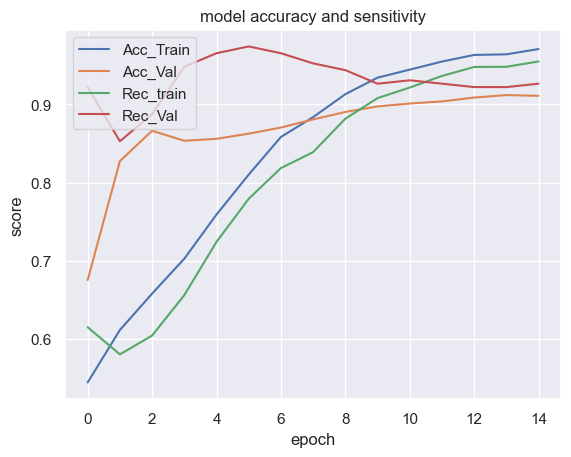

In [39]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.title('model accuracy and sensitivity')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['Acc_Train', 'Acc_Val', 'Rec_train', 'Rec_Val'], loc='upper left')
plt.show()

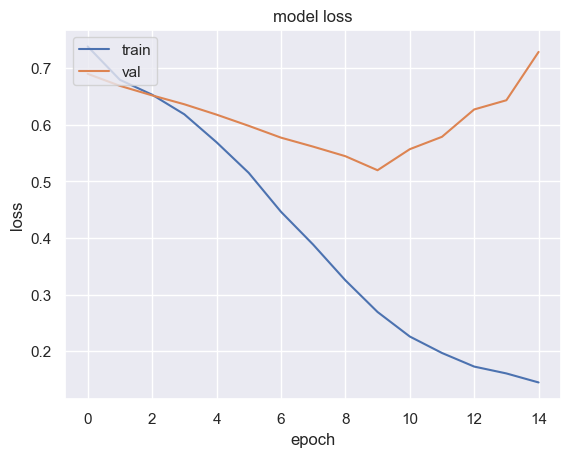

In [40]:
# plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Confusion matrix:

209/209 [==============================] - 1s 4ms/step
Confusion Matrix:


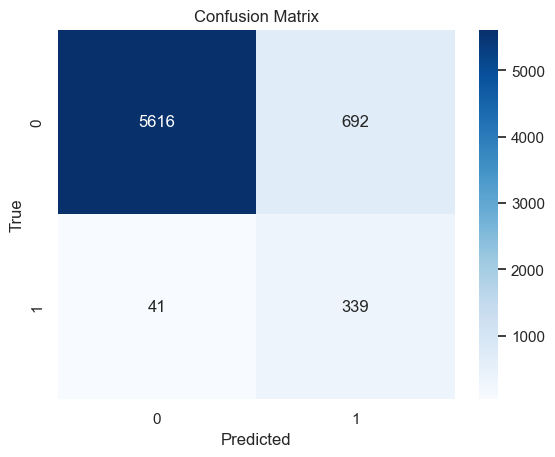

In [ ]:
# Confusion matrix
confusion = confusion_matrix(y_true=y_test, y_pred=model.predict(x_test_pca)>0.5)
print("Confusion Matrix:")
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()